# DenseNet 안면 Multi-Label (성별/나이) Classification

In [1]:
from keras.models import Sequential
"""Import from keras_preprocessing not from keras.preprocessing, because Keras may or maynot contain the features discussed here depending upon when you read this article, until the keras_preprocessed library is updated in Keras use the github version."""
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

### 데이터프레임 로드

In [26]:
df=pd.read_csv('data/FamilyData/Val/FamilyData_Val_DF.csv',index_col=0)
df[:10]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
0,F0801_IND_F_48_-45_01.JPG,1,0,0,0,0,0,1,0,0
1,F0801_IND_F_48_-45_02.JPG,1,0,0,0,0,0,1,0,0
2,F0801_IND_F_48_-90_01.JPG,1,0,0,0,0,0,1,0,0
3,F0801_IND_F_48_-90_02.JPG,1,0,0,0,0,0,1,0,0
4,F0801_IND_F_48_0_01.JPG,1,0,0,0,0,0,1,0,0
5,F0801_IND_F_48_0_02.JPG,1,0,0,0,0,0,1,0,0
6,F0801_IND_F_48_45_01.JPG,1,0,0,0,0,0,1,0,0
7,F0801_IND_F_48_45_02.JPG,1,0,0,0,0,0,1,0,0
8,F0801_IND_F_48_90_01.JPG,1,0,0,0,0,0,1,0,0
9,F0801_IND_F_48_90_02.JPG,1,0,0,0,0,0,1,0,0


In [27]:
df_shuffled=df.sample(frac=1).reset_index(drop=True)
df_shuffled

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
0,F0879_IND_M_46_45_01.JPG,0,1,0,0,0,0,1,0,0
1,F0871_IND_D2_8_-90_02.JPG,0,1,1,0,0,0,0,0,0
2,F0835_IND_D_13_90_01.JPG,0,1,0,1,0,0,0,0,0
3,F0814_IND_F_53_-90_02.JPG,1,0,0,0,0,0,0,1,0
4,F0862_IND_M_55_90_02.JPG,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
3195,F0841_IND_F_45_-45_02.jpg,1,0,0,0,0,0,1,0,0
3196,F0859_IND_S_31_-45_02.JPG,1,0,0,0,0,1,0,0,0
3197,F0870_IND_F_50_-90_02.JPG,1,0,0,0,0,0,0,1,0
3198,F0861_IND_D_21_90_02.JPG,0,1,0,0,1,0,0,0,0


In [28]:
df = df_shuffled

In [29]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, random_state=777, test_size=0.2,shuffle=True)
train_df, val_df = train_test_split(train_df, random_state=777, test_size=0.2,shuffle=True)

len(train_df) , len(val_df), len(test_df)

(2048, 512, 640)

In [30]:
train_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
2371,F0813_IND_S4_10_45_01.JPG,1,0,0,1,0,0,0,0,0
1432,F0885_IND_D_26_90_01.JPG,0,1,0,0,1,0,0,0,0
356,F0825_IND_S_14_-45_01.JPG,1,0,0,1,0,0,0,0,0
1501,F0837_IND_S_15_45_02.JPG,1,0,0,1,0,0,0,0,0
22,F0889_IND_S_11_0_01.JPG,1,0,0,1,0,0,0,0,0


In [31]:
val_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
3017,F0885_IND_F_53_-90_02.JPG,1,0,0,0,0,0,0,1,0
1039,F0822_IND_F_58_90_02.JPG,1,0,0,0,0,0,0,1,0
2966,F0829_IND_D2_10_-45_01.JPG,0,1,0,1,0,0,0,0,0
45,F0861_IND_D_21_45_02.JPG,0,1,0,0,1,0,0,0,0
527,F0813_IND_M_47_45_01.JPG,0,1,0,0,0,0,1,0,0


In [32]:
test_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
186,F0832_IND_D_11_-45_01.JPG,0,1,0,1,0,0,0,0,0
621,F0868_IND_F_63_45_02.JPG,1,0,0,0,0,0,0,0,1
980,F0819_IND_S_27_0_01.JPG,1,0,0,0,1,0,0,0,0
1648,F0861_IND_S_25_-90_02.JPG,1,0,0,0,1,0,0,0,0
3193,F0862_IND_S_25_0_01.JPG,1,0,0,0,1,0,0,0,0


In [33]:
columns= list(df.columns)[1:]
columns

['M', 'F', "0's", "10's", "20's", "30's", "40's", "50's", '60+']

### ImageGenerator 정의

In [34]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [35]:
preprocessed_data_path = 'E:/045.가족 관계가 알려진 얼굴 이미지 데이터/01.데이터/Preprocessed_Datasets'

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=777,
    shuffle=True,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 2048 validated image filenames.


In [36]:
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=777,
    shuffle=True,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 512 validated image filenames.


In [37]:
# test_generator은 batch_size 1개씩
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=777,
    shuffle=False,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 640 validated image filenames.


### 모델 정의

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization

# 레이어 추가 시
# include_top = False 
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
output = model_d.output

x= GlobalAveragePooling2D()(output)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(9,activation='sigmoid')(x) #FC-layer

In [39]:
model=Model(inputs=model_d.input,outputs=preds)
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

### 모델 학습

In [40]:
epochs = 5

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=valid_generator)

Epoch 1/5
64/64 [==============================] - 404s 6s/step - loss: 0.7425 - acc: 0.5391 - val_loss: 12.1939 - val_acc: 0.4375
Epoch 2/5
64/64 [==============================] - 361s 6s/step - loss: 0.4722 - acc: 0.8501 - val_loss: 3.1120 - val_acc: 0.3750
Epoch 3/5
64/64 [==============================] - 360s 6s/step - loss: 0.3619 - acc: 0.9053 - val_loss: 3.7070 - val_acc: 0.3867
Epoch 4/5
64/64 [==============================] - 360s 6s/step - loss: 0.3043 - acc: 0.9258 - val_loss: 0.3956 - val_acc: 0.8125
Epoch 5/5
64/64 [==============================] - 362s 6s/step - loss: 0.2561 - acc: 0.9360 - val_loss: 0.2977 - val_acc: 0.8516


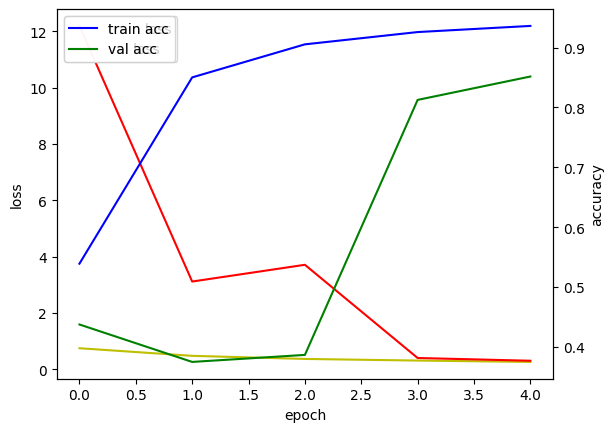

In [41]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

### 모델 평가

In [42]:
model.evaluate(test_generator)

20/20 [==============================] - 77s 4s/step - loss: 0.3011 - acc: 0.8578


[0.3010513484477997, 0.8578125238418579]

In [43]:
pred=model.predict(test_generator)
pred[0].round(3)

20/20 [==============================] - 36s 2s/step


array([0.005, 0.994, 0.157, 0.657, 0.027, 0.042, 0.054, 0.01 , 0.006],
      dtype=float32)

In [44]:
pred[0].argsort()[::-1]

array([1, 3, 2, 6, 5, 4, 7, 8, 0], dtype=int64)